# What European Soccer Team Attributes Lead To More Wins?

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>  
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

In this project, I will use the Kaggle "European Soccer Database" which can be found at https://www.kaggle.com/hugomathien/soccer. The "European Soccer Database" consists on 7 tables: Country, League, Match, Player, Player_Attributes, Team and Team_Attributes.
<br/>

The **Match** table contains data over 8 soccer seasons and stores: the date a match was played, the teams that played the match, the number of goals each team made, the players in the match and other match statistics.


The **Player** table contains players name and vital statistics such as weight, height and birthdate.


The **Player_Attributes** table contains the players statistics such as their overall rating, potential, prefered foot etc.


The **Team_Attributes** table records the team's attributes such as build up play, chance creation and defence scores at a given time.


The **Team** table stores team id and team names that are used for referencing.


The **Country** table stores the country id and country name used for referencing.


The **League** tables stores league id, country id and league name used for referencing.

<br/>


I will be analyzing a dataset derived from the "European Soccer Database". The dataset ecompasses data from the Match, Team, Team_Attributes, Country and League tables. The Dataset was derived usng the SQL query below:

~~~~sql
CREATE TABLE team_match_data AS 
WITH team_data AS (
SELECT * 
FROM Team_Attributes ta
JOIN Team t
ON ta.team_api_id = t.team_api_id),


	teamdate_data AS (
SELECT *,
lead(team_api_id) OVER (PARTITION BY team_api_id ORDER BY "date") AS lead_team_api_id,
lead("date",1,"2016-05-25 00:00:00") OVER (PARTITION BY team_api_id ORDER BY "date") AS end_date
FROM team_data)


SELECT m.match_api_id, 
m."date" match_dt,
m.country_id,
c.name country_name,
m.league_id,
l.name league_name,
m.season,
m.home_team_api_id,
m.away_team_api_id,
td.team_api_id,
td.team_long_name,
td.team_short_name,
m.home_team_goal,
m.away_team_goal,
td."date" t_attr_start_dt,
td.end_date t_attr_end_dt,
td.buildUpPlaySpeed bu_play_speed,
td.buildUpPlaySpeedClass bu_play_speed_class,
td.buildUpPlayDribbling bu_play_dribbling,
td.buildUpPlayDribblingClass bu_play_dribbling_class,
td.buildUpPlayPassing bu_play_passing,
td.buildUpPlayPassingClass bu_play_passing_class,
td.buildUpPlayPositioningClass bu_play_positioning_class,
td.chanceCreationPassing cc_passing,
td.chanceCreationPassingClass cc_passing_class,
td.chanceCreationCrossing cc_crossing,
td.chanceCreationCrossingClass cc_crossing_class,
td.chanceCreationShooting cc_shooting,
td.chanceCreationShootingClass cc_shooting_class,
td.chanceCreationPositioningClass cc_positioning_class,
td.defencePressure defence_pressure,
td.defencePressureClass defence_pressure_class,
td.defenceAggression defence_aggression,
td.defenceAggressionClass defence_agression_class,
td.defenceTeamWidth defence_team_width,
td.defenceTeamWidthClass defence_team_width_class,
td.defenceDefenderLineClass defence_line_class
FROM Match m
JOIN teamdate_data td
ON td.team_api_id = m.home_team_api_id
OR td.team_api_id = m.away_team_api_id
JOIN League l
ON l.id = m.league_id
JOIN Country c
ON c.id = m.country_id
WHERE m."date"  BETWEEN td."date" AND td.end_date
ORDER BY td.team_api_id, td.end_date DESC;
~~~~
<br/>

### Questions
I will be focusing on team goals and how their attributes contributed to these goals.

1. Which Teams won the most matches?
2. What team attributes contribute to the most wins?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling



### General Properties

In [2]:
df = pd.read_csv('team_match_data.csv')
df.head()

,match_api_id,match_dt,country_id,country_name,league_id,league_name,season,home_team_api_id,away_team_api_id,team_api_id,...,cc_shooting,cc_shooting_class,cc_positioning_class,defence_pressure,defence_pressure_class,defence_aggression,defence_agression_class,defence_team_width,defence_team_width_class,defence_line_class
0,1994692,2015-09-26 00:00:00,15722,Poland,15722,Poland Ekstraklasa,2015/2016,2186,1601,1601,...,50,Normal,Organised,43,Medium,44,Press,49,Normal,Cover
1,1994701,2015-10-02 00:00:00,15722,Poland,15722,Poland Ekstraklasa,2015/2016,1601,8023,1601,...,50,Normal,Organised,43,Medium,44,Press,49,Normal,Cover
2,1994710,2015-10-17 00:00:00,15722,Poland,15722,Poland Ekstraklasa,2015/2016,2182,1601,1601,...,50,Normal,Organised,43,Medium,44,Press,49,Normal,Cover
3,1994716,2015-10-23 00:00:00,15722,Poland,15722,Poland Ekstraklasa,2015/2016,1601,8025,1601,...,50,Normal,Organised,43,Medium,44,Press,49,Normal,Cover
4,1994723,2015-10-30 00:00:00,15722,Poland,15722,Poland Ekstraklasa,2015/2016,10265,1601,1601,...,50,Normal,Organised,43,Medium,44,Press,49,Normal,Cover


Imported the **team_match_data** csv file into a data frame and viewed the first 5 rows

In [3]:
df.shape

(39882, 37)

There are **39,882 rows** and **37 columns** in the data frame

In [4]:
df.describe()

,match_api_id,country_id,league_id,home_team_api_id,away_team_api_id,team_api_id,home_team_goal,away_team_goal,bu_play_speed,bu_play_dribbling,bu_play_passing,cc_passing,cc_crossing,cc_shooting,defence_pressure,defence_aggression,defence_team_width
count,3.988200e+04,39882.000000,39882.000000,39882.000000,39882.000000,39882.000000,39882.000000,39882.000000,39882.000000,11749.000000,39882.000000,39882.000000,39882.000000,39882.000000,39882.000000,39882.000000,39882.000000
mean,1.360436e+06,11763.067148,11763.067148,9956.776992,9954.216087,9665.847425,1.554787,1.173888,52.412818,49.088433,47.927210,52.411664,54.034627,54.270473,46.466978,49.474625,52.337596
std,4.222426e+05,7520.607243,7520.607243,13767.842735,13738.480474,11287.448154,1.306828,1.147342,11.930429,9.800439,11.081696,10.400321,11.184020,10.440281,10.215524,9.871917,9.435304
min,6.541530e+05,1.000000,1.000000,1601.000000,1601.000000,1601.000000,0.000000,0.000000,20.000000,24.000000,20.000000,21.000000,20.000000,22.000000,23.000000,24.000000,30.000000
25%,1.025090e+06,4769.000000,4769.000000,8472.000000,8472.000000,8481.000000,1.000000,0.000000,45.000000,42.000000,39.000000,47.000000,48.000000,49.000000,39.000000,44.000000,48.000000
50%,1.260174e+06,10257.000000,10257.000000,8697.000000,8697.000000,8721.000000,1.000000,1.000000,52.000000,49.000000,49.000000,52.000000,53.000000,54.000000,46.000000,48.000000,52.000000
75%,1.724266e+06,17642.000000,17642.000000,9925.000000,9925.000000,9925.000000,2.000000,2.000000,62.000000,55.000000,55.000000,60.000000,63.000000,62.000000,53.000000,56.000000,59.000000
max,2.216672e+06,24558.000000,24558.000000,274581.000000,274581.000000,274581.000000,10.000000,9.000000,80.000000,77.000000,80.000000,80.000000,80.000000,80.000000,72.000000,72.000000,73.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39882 entries, 0 to 39881
Data columns (total 37 columns):
match_api_id                 39882 non-null int64
match_dt                     39882 non-null object
country_id                   39882 non-null int64
country_name                 39882 non-null object
league_id                    39882 non-null int64
league_name                  39882 non-null object
season                       39882 non-null object
home_team_api_id             39882 non-null int64
away_team_api_id             39882 non-null int64
team_api_id                  39882 non-null int64
team_long_name               39882 non-null object
team_short_name              39882 non-null object
home_team_goal               39882 non-null int64
away_team_goal               39882 non-null int64
t_attr_start_dt              39882 non-null object
t_attr_end_dt                39882 non-null object
bu_play_speed                39882 non-null int64
bu_play_speed_class          3988

The **bu_play_dribbling** column has null data. There are *27,133 records* with null data

### Data Cleaning 


The data contains **39,882 rows** and **37 columns**.

The data consists of match data, team data, and team attribute data at the time the match took place.
For each team attribute respresented with a numerical value, there is a corresponding classifaction.


The **match_api_id, country_id, country_name, league_id, league_name** and **season** columns can be dropped since they are not relevant to determine how a team's attributes contribute to their wins.

The data will need to be cleaned, to fill the null values for the **bu_play_dribbling** column. 
This will be done by determing with class the null value corresponds to and filled with the mean of that class.

In [6]:
# Drop columns that are not needed
df.drop(['match_api_id','country_id','league_id','country_name','league_name', 'season'], axis=1, inplace = True)

In [7]:
df.head()

,match_dt,home_team_api_id,away_team_api_id,team_api_id,team_long_name,team_short_name,home_team_goal,away_team_goal,t_attr_start_dt,t_attr_end_dt,...,cc_shooting,cc_shooting_class,cc_positioning_class,defence_pressure,defence_pressure_class,defence_aggression,defence_agression_class,defence_team_width,defence_team_width_class,defence_line_class
0,2015-09-26 00:00:00,2186,1601,1601,Ruch Chorzów,CHO,2,1,2015-09-10 00:00:00,2016-05-25 00:00:00,...,50,Normal,Organised,43,Medium,44,Press,49,Normal,Cover
1,2015-10-02 00:00:00,1601,8023,1601,Ruch Chorzów,CHO,0,2,2015-09-10 00:00:00,2016-05-25 00:00:00,...,50,Normal,Organised,43,Medium,44,Press,49,Normal,Cover
2,2015-10-17 00:00:00,2182,1601,1601,Ruch Chorzów,CHO,2,2,2015-09-10 00:00:00,2016-05-25 00:00:00,...,50,Normal,Organised,43,Medium,44,Press,49,Normal,Cover
3,2015-10-23 00:00:00,1601,8025,1601,Ruch Chorzów,CHO,1,0,2015-09-10 00:00:00,2016-05-25 00:00:00,...,50,Normal,Organised,43,Medium,44,Press,49,Normal,Cover
4,2015-10-30 00:00:00,10265,1601,1601,Ruch Chorzów,CHO,0,0,2015-09-10 00:00:00,2016-05-25 00:00:00,...,50,Normal,Organised,43,Medium,44,Press,49,Normal,Cover


In [8]:
df.shape

(39882, 31)

After dropping the columns, there are now **39,882 rows** and **31 columns** in the data frame

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39882 entries, 0 to 39881
Data columns (total 31 columns):
match_dt                     39882 non-null object
home_team_api_id             39882 non-null int64
away_team_api_id             39882 non-null int64
team_api_id                  39882 non-null int64
team_long_name               39882 non-null object
team_short_name              39882 non-null object
home_team_goal               39882 non-null int64
away_team_goal               39882 non-null int64
t_attr_start_dt              39882 non-null object
t_attr_end_dt                39882 non-null object
bu_play_speed                39882 non-null int64
bu_play_speed_class          39882 non-null object
bu_play_dribbling            11749 non-null float64
bu_play_dribbling_class      39882 non-null object
bu_play_passing              39882 non-null int64
bu_play_passing_class        39882 non-null object
bu_play_positioning_class    39882 non-null object
cc_passing                   3

The **bu_play_dribbling** column has null data. There are *27,133 records* with null data

In [10]:
# Find the bu_play_dribbling clases
df.bu_play_dribbling_class.unique()

array(['Normal', 'Little', 'Lots'], dtype=object)

There are 3 classes for **bu_play_dribbling**: *Normal, Little and Lots*

In [11]:
df[df.bu_play_dribbling.isnull()]['bu_play_dribbling_class'].unique()

array(['Little'], dtype=object)

All of the null values from the **bu_play_dribbling** column belong to the **bu_play_dribbling_class** *Little*. 

We need to fill those null values with the mean of the *Little* **bu_play_dribbling** columns

In [12]:
# Normal Build Up Dribblig Class df
df_normal_dribbling_class = df.query('bu_play_dribbling_class == "Normal"')

Created a data frame for the *Normal* **bu_play_dribbling_class**

In [13]:
# Range for Normal Build Up Dribblig
(df_normal_dribbling_class.bu_play_dribbling.min(), df_normal_dribbling_class.bu_play_dribbling.max())

(34.0, 66.0)

The range of values for the *Normal* **bu_play_dribbling_class** is (34.0, 66.0)

In [14]:
# Lots Build Up Dribblig Class df
df_lots_dribbling_class = df.query('bu_play_dribbling_class == "Lots"')

Created a data frame for the *Lots* **bu_play_dribbling_class**

In [15]:
# Range for Lots Build Up Dribblig
(df_lots_dribbling_class.bu_play_dribbling.min(),df_lots_dribbling_class.bu_play_dribbling.max())

(67.0, 77.0)

The range of values for the *Lots* **bu_play_dribbling_class** is (67.0, 77.0)

In [16]:
# Little Build Up Dribblig Class df
df_little_dribbling_class = df.query('bu_play_dribbling_class == "Little"')

Created a data frame for the *Little* **bu_play_dribbling_class**

In [17]:
# Range for Little Build Up Dribblig
(df_little_dribbling_class.bu_play_dribbling.min(),df_little_dribbling_class.bu_play_dribbling.max())

(24.0, 33.0)

The range of values for the *Little* **bu_play_dribbling_class** is (24.0, 33.0)

In [18]:
# Find the mean of the Little Build Up Dribbling class df
df_little_dribbling_class['bu_play_dribbling'].mean()

30.44859813084112

The mean of the **bu_play_dribbling_class** for the *Little* class is 30.44859813084112

In [19]:
# Fill nan values with the mean of the litle dribbling class since they were all inthe little dribblng class
df['bu_play_dribbling'].fillna(df_little_dribbling_class['bu_play_dribbling'].mean(), inplace=True)

The null values for **bu_play_dribbling** were filled with the mean of the *Little* class

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39882 entries, 0 to 39881
Data columns (total 31 columns):
match_dt                     39882 non-null object
home_team_api_id             39882 non-null int64
away_team_api_id             39882 non-null int64
team_api_id                  39882 non-null int64
team_long_name               39882 non-null object
team_short_name              39882 non-null object
home_team_goal               39882 non-null int64
away_team_goal               39882 non-null int64
t_attr_start_dt              39882 non-null object
t_attr_end_dt                39882 non-null object
bu_play_speed                39882 non-null int64
bu_play_speed_class          39882 non-null object
bu_play_dribbling            39882 non-null float64
bu_play_dribbling_class      39882 non-null object
bu_play_passing              39882 non-null int64
bu_play_passing_class        39882 non-null object
bu_play_positioning_class    39882 non-null object
cc_passing                   3

The **bu_play_dribbling** column has all null values filled

In [21]:
df.duplicated().sum()

0

There are **no duplicates** in the data frame

In [22]:
df.shape

(39882, 31)

There are still **39,882 rows** and **31 columns** in the data frame

In [23]:
df.describe()

,home_team_api_id,away_team_api_id,team_api_id,home_team_goal,away_team_goal,bu_play_speed,bu_play_dribbling,bu_play_passing,cc_passing,cc_crossing,cc_shooting,defence_pressure,defence_aggression,defence_team_width
count,39882.000000,39882.000000,39882.000000,39882.000000,39882.000000,39882.000000,39882.000000,39882.000000,39882.000000,39882.000000,39882.000000,39882.000000,39882.000000,39882.000000
mean,9956.776992,9954.216087,9665.847425,1.554787,1.173888,52.412818,35.939783,47.927210,52.411664,54.034627,54.270473,46.466978,49.474625,52.337596
std,13767.842735,13738.480474,11287.448154,1.306828,1.147342,11.930429,10.024826,11.081696,10.400321,11.184020,10.440281,10.215524,9.871917,9.435304
min,1601.000000,1601.000000,1601.000000,0.000000,0.000000,20.000000,24.000000,20.000000,21.000000,20.000000,22.000000,23.000000,24.000000,30.000000
25%,8472.000000,8472.000000,8481.000000,1.000000,0.000000,45.000000,30.448598,39.000000,47.000000,48.000000,49.000000,39.000000,44.000000,48.000000
50%,8697.000000,8697.000000,8721.000000,1.000000,1.000000,52.000000,30.448598,49.000000,52.000000,53.000000,54.000000,46.000000,48.000000,52.000000
75%,9925.000000,9925.000000,9925.000000,2.000000,2.000000,62.000000,38.000000,55.000000,60.000000,63.000000,62.000000,53.000000,56.000000,59.000000
max,274581.000000,274581.000000,274581.000000,10.000000,9.000000,80.000000,77.000000,80.000000,80.000000,80.000000,80.000000,72.000000,72.000000,73.000000


<a id='eda'></a>
## Exploratory Data Analysis



### Question 1 : Which Teams won the most matches?

In [24]:
# Use this, and more code cells, to explore your data. Don't forget to add
#   Markdown cells to document your observations and findings.

# Get matches that did not result in a Tied Match
df_match_no_draw = df.query('home_team_goal != away_team_goal')

In [25]:
df_match_no_draw.shape

(29758, 31)

There are **29,758 records** that consist of matches that resulted in no draw

In [26]:
df_match_no_draw.describe()

,home_team_api_id,away_team_api_id,team_api_id,home_team_goal,away_team_goal,bu_play_speed,bu_play_dribbling,bu_play_passing,cc_passing,cc_crossing,cc_shooting,defence_pressure,defence_aggression,defence_team_width
count,29758.000000,29758.000000,29758.000000,29758.000000,29758.000000,29758.000000,29758.000000,29758.000000,29758.000000,29758.000000,29758.000000,29758.000000,29758.00000,29758.000000
mean,9961.051415,9899.828685,9626.486491,1.743733,1.233248,52.347402,35.914585,47.896129,52.440117,54.045433,54.308354,46.573190,49.51361,52.355400
std,13757.721340,13420.665962,10930.258097,1.381442,1.229052,11.931015,9.982912,11.071162,10.413259,11.176362,10.476461,10.228084,9.87437,9.414251
min,1601.000000,1601.000000,1601.000000,0.000000,0.000000,20.000000,24.000000,20.000000,21.000000,20.000000,22.000000,23.000000,24.00000,30.000000
25%,8481.000000,8472.000000,8483.000000,1.000000,0.000000,45.000000,30.448598,39.000000,47.000000,48.000000,49.000000,39.000000,44.00000,48.000000
50%,8697.000000,8697.000000,8721.000000,2.000000,1.000000,52.000000,30.448598,49.000000,52.000000,53.000000,54.000000,46.000000,48.00000,52.000000
75%,9925.000000,9925.000000,9925.000000,3.000000,2.000000,62.000000,38.000000,55.000000,60.000000,63.000000,63.000000,53.000000,56.00000,59.000000
max,274581.000000,274581.000000,274581.000000,10.000000,9.000000,80.000000,77.000000,80.000000,80.000000,80.000000,80.000000,72.000000,72.00000,73.000000


In [27]:
#Create a column to identify the winning team
df_match_no_draw['win_team_id'] = np.where(df_match_no_draw['home_team_goal'] > df_match_no_draw['away_team_goal'], df_match_no_draw['home_team_api_id'], df_match_no_draw['away_team_api_id'])

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [28]:
df_match_no_draw.head()

,match_dt,home_team_api_id,away_team_api_id,team_api_id,team_long_name,team_short_name,home_team_goal,away_team_goal,t_attr_start_dt,t_attr_end_dt,...,cc_shooting_class,cc_positioning_class,defence_pressure,defence_pressure_class,defence_aggression,defence_agression_class,defence_team_width,defence_team_width_class,defence_line_class,win_team_id
0,2015-09-26 00:00:00,2186,1601,1601,Ruch Chorzów,CHO,2,1,2015-09-10 00:00:00,2016-05-25 00:00:00,...,Normal,Organised,43,Medium,44,Press,49,Normal,Cover,2186
1,2015-10-02 00:00:00,1601,8023,1601,Ruch Chorzów,CHO,0,2,2015-09-10 00:00:00,2016-05-25 00:00:00,...,Normal,Organised,43,Medium,44,Press,49,Normal,Cover,8023
3,2015-10-23 00:00:00,1601,8025,1601,Ruch Chorzów,CHO,1,0,2015-09-10 00:00:00,2016-05-25 00:00:00,...,Normal,Organised,43,Medium,44,Press,49,Normal,Cover,1601
5,2015-11-07 00:00:00,1601,8030,1601,Ruch Chorzów,CHO,3,2,2015-09-10 00:00:00,2016-05-25 00:00:00,...,Normal,Organised,43,Medium,44,Press,49,Normal,Cover,1601
6,2015-11-21 00:00:00,8019,1601,1601,Ruch Chorzów,CHO,0,3,2015-09-10 00:00:00,2016-05-25 00:00:00,...,Normal,Organised,43,Medium,44,Press,49,Normal,Cover,1601


In [29]:
# Filter the teams attributes for the team that won
df_win_team = df_match_no_draw.query('team_api_id == win_team_id')

In [30]:
df_win_team.shape

(15010, 32)

There are **15,010 matches** that resulted in a win

In [31]:
df_win_team.head()

,match_dt,home_team_api_id,away_team_api_id,team_api_id,team_long_name,team_short_name,home_team_goal,away_team_goal,t_attr_start_dt,t_attr_end_dt,...,cc_shooting_class,cc_positioning_class,defence_pressure,defence_pressure_class,defence_aggression,defence_agression_class,defence_team_width,defence_team_width_class,defence_line_class,win_team_id
3,2015-10-23 00:00:00,1601,8025,1601,Ruch Chorzów,CHO,1,0,2015-09-10 00:00:00,2016-05-25 00:00:00,...,Normal,Organised,43,Medium,44,Press,49,Normal,Cover,1601
5,2015-11-07 00:00:00,1601,8030,1601,Ruch Chorzów,CHO,3,2,2015-09-10 00:00:00,2016-05-25 00:00:00,...,Normal,Organised,43,Medium,44,Press,49,Normal,Cover,1601
6,2015-11-21 00:00:00,8019,1601,1601,Ruch Chorzów,CHO,0,3,2015-09-10 00:00:00,2016-05-25 00:00:00,...,Normal,Organised,43,Medium,44,Press,49,Normal,Cover,1601
8,2015-12-01 00:00:00,1601,8245,1601,Ruch Chorzów,CHO,2,1,2015-09-10 00:00:00,2016-05-25 00:00:00,...,Normal,Organised,43,Medium,44,Press,49,Normal,Cover,1601
11,2015-12-19 00:00:00,177361,1601,1601,Ruch Chorzów,CHO,0,1,2015-09-10 00:00:00,2016-05-25 00:00:00,...,Normal,Organised,43,Medium,44,Press,49,Normal,Cover,1601


In [32]:
# Count the number of wins for each team and sort in decending order
df_num_wins=df_win_team.groupby(['team_long_name'])['win_team_id'].count().sort_values(ascending=False)

In [33]:
# Top Ten Soccer Teams
top_10 = df_num_wins.head(10)

In [34]:
top_10

team_long_name
FC Barcelona           189
Real Madrid CF         185
Celtic                 180
FC Bayern Munich       159
Juventus               156
SL Benfica             153
FC Porto               149
Manchester City        148
Paris Saint-Germain    147
Manchester United      146
Name: win_team_id, dtype: int64


The **Top 10** European Soccer teams with the most wins are:

FC Barcelona, Real Madrid CF, Celtic, FC Bayern Munich, Juventus, SL Benfica, FC Porto, Manchester City, Paris, Saint-Germain, Manchester United     

In [35]:
df_num_wins.idxmax()

'FC Barcelona'

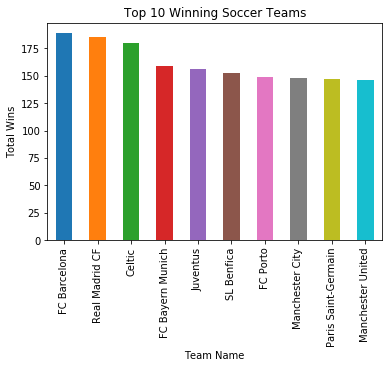

In [36]:
# Plot a bar chart showing the Top 10 Soccer Teams
top_10.plot(kind='bar');
plt.title('Top 10 Winning Soccer Teams')
plt.xlabel('Team Name')
plt.ylabel('Total Wins');

### Question 2  : What team attributes contribute to the most wins?

In [37]:
# Count the number of wins for an attribute period
df_win_team.groupby(['win_team_id','team_long_name','t_attr_start_dt','t_attr_end_dt'])['win_team_id'].count()

win_team_id  team_long_name           t_attr_start_dt      t_attr_end_dt      
1601         Ruch Chorzów             2010-02-22 00:00:00  2011-02-22 00:00:00    10
                                      2011-02-22 00:00:00  2012-02-22 00:00:00    15
                                      2012-02-22 00:00:00  2013-09-20 00:00:00    16
                                      2013-09-20 00:00:00  2014-09-19 00:00:00    14
                                      2014-09-19 00:00:00  2015-09-10 00:00:00    10
                                      2015-09-10 00:00:00  2016-05-25 00:00:00     8
1773         Oud-Heverlee Leuven      2012-02-22 00:00:00  2013-09-20 00:00:00     9
                                      2014-09-19 00:00:00  2016-05-25 00:00:00     7
1957         Jagiellonia Białystok    2010-02-22 00:00:00  2011-02-22 00:00:00    14
                                      2011-02-22 00:00:00  2012-02-22 00:00:00    11
                                      2012-02-22 00:00:00  2013-09-20 0

This shows the number of wins a team had with during a given team attribute start and end time

In [38]:
df_win_team['wins_by_attribute_period'] = df_win_team.groupby(['win_team_id','t_attr_start_dt','t_attr_end_dt'])['win_team_id'].transform("size")

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [39]:
df_win_team.head()

,match_dt,home_team_api_id,away_team_api_id,team_api_id,team_long_name,team_short_name,home_team_goal,away_team_goal,t_attr_start_dt,t_attr_end_dt,...,cc_positioning_class,defence_pressure,defence_pressure_class,defence_aggression,defence_agression_class,defence_team_width,defence_team_width_class,defence_line_class,win_team_id,wins_by_attribute_period
3,2015-10-23 00:00:00,1601,8025,1601,Ruch Chorzów,CHO,1,0,2015-09-10 00:00:00,2016-05-25 00:00:00,...,Organised,43,Medium,44,Press,49,Normal,Cover,1601,8
5,2015-11-07 00:00:00,1601,8030,1601,Ruch Chorzów,CHO,3,2,2015-09-10 00:00:00,2016-05-25 00:00:00,...,Organised,43,Medium,44,Press,49,Normal,Cover,1601,8
6,2015-11-21 00:00:00,8019,1601,1601,Ruch Chorzów,CHO,0,3,2015-09-10 00:00:00,2016-05-25 00:00:00,...,Organised,43,Medium,44,Press,49,Normal,Cover,1601,8
8,2015-12-01 00:00:00,1601,8245,1601,Ruch Chorzów,CHO,2,1,2015-09-10 00:00:00,2016-05-25 00:00:00,...,Organised,43,Medium,44,Press,49,Normal,Cover,1601,8
11,2015-12-19 00:00:00,177361,1601,1601,Ruch Chorzów,CHO,0,1,2015-09-10 00:00:00,2016-05-25 00:00:00,...,Organised,43,Medium,44,Press,49,Normal,Cover,1601,8


In [40]:
df_win_team.drop(['match_dt','home_team_api_id','away_team_api_id','team_api_id','home_team_goal','away_team_goal'],axis=1, inplace=True)

/root/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Remove the columns that are no longer necessary: **match_dt, home_team_api_id, away_team_api_id, team_api_id, home_team_goal and away_team_goal**

In [41]:
df_win_team.duplicated().sum()

13864

There are **13,864** duplicate records for winning matches. 

In [42]:
df_win_team.drop_duplicates(inplace=True)

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Drop the duplicates from the data frane

In [43]:
df_win_team.duplicated().sum()

0

There are no more duplicates

In [44]:
df_win_team.head()

,team_long_name,team_short_name,t_attr_start_dt,t_attr_end_dt,bu_play_speed,bu_play_speed_class,bu_play_dribbling,bu_play_dribbling_class,bu_play_passing,bu_play_passing_class,...,cc_positioning_class,defence_pressure,defence_pressure_class,defence_aggression,defence_agression_class,defence_team_width,defence_team_width_class,defence_line_class,win_team_id,wins_by_attribute_period
3,Ruch Chorzów,CHO,2015-09-10 00:00:00,2016-05-25 00:00:00,47,Balanced,48.000000,Normal,38,Mixed,...,Organised,43,Medium,44,Press,49,Normal,Cover,1601,8
28,Ruch Chorzów,CHO,2014-09-19 00:00:00,2015-09-10 00:00:00,53,Balanced,48.000000,Normal,38,Mixed,...,Organised,43,Medium,44,Press,49,Normal,Cover,1601,10
53,Ruch Chorzów,CHO,2013-09-20 00:00:00,2014-09-19 00:00:00,53,Balanced,30.448598,Little,55,Mixed,...,Organised,43,Medium,44,Press,49,Normal,Cover,1601,14
83,Ruch Chorzów,CHO,2012-02-22 00:00:00,2013-09-20 00:00:00,53,Balanced,30.448598,Little,55,Mixed,...,Organised,43,Medium,44,Press,49,Normal,Cover,1601,16
134,Ruch Chorzów,CHO,2011-02-22 00:00:00,2012-02-22 00:00:00,48,Balanced,30.448598,Little,51,Mixed,...,Organised,46,Medium,48,Press,50,Normal,Cover,1601,15


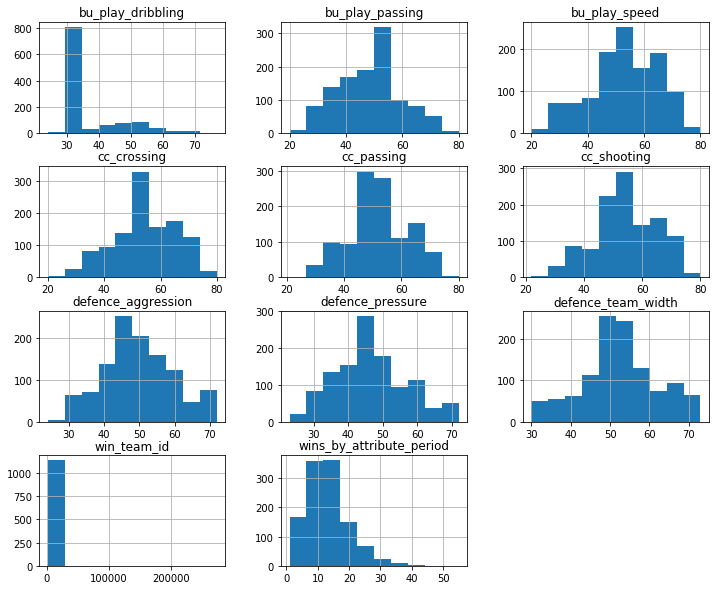

In [45]:
df_win_team.hist(figsize=(12,10));

#### Scatterplot of wins against various features

Text(0, 0.5, 'Team Wins')

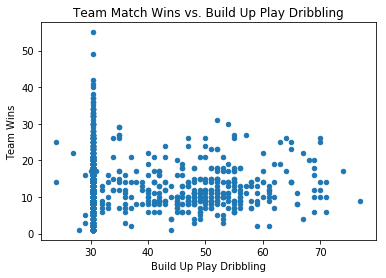

In [56]:
df_win_team.plot(x="bu_play_dribbling", y="wins_by_attribute_period", kind="scatter");
plt.title("Team Match Wins vs. Build Up Play Dribbling")
plt.xlabel("Build Up Play Dribbling")
plt.ylabel("Team Wins")

There is no correlation between the number of wins and **build up play dribbling**

Text(0, 0.5, 'Team Wins')

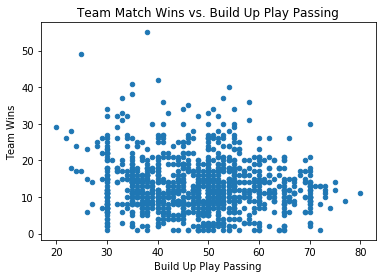

In [57]:
df_win_team.plot(x="bu_play_passing", y="wins_by_attribute_period", kind="scatter");
plt.title("Team Match Wins vs. Build Up Play Passing")
plt.xlabel("Build Up Play Passing")
plt.ylabel("Team Wins")

There is no correlation between wins and **build up play passing**

Text(0, 0.5, 'Team Wins')

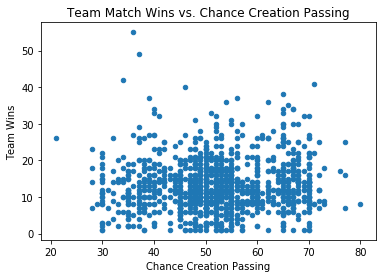

In [58]:
df_win_team.plot(x="cc_passing", y="wins_by_attribute_period", kind="scatter");
plt.title("Team Match Wins vs. Chance Creation Passing")
plt.xlabel("Chance Creation Passing")
plt.ylabel("Team Wins")

There is no correlation between the number of wins and **chance creation passing**

Text(0, 0.5, 'Team Wins')

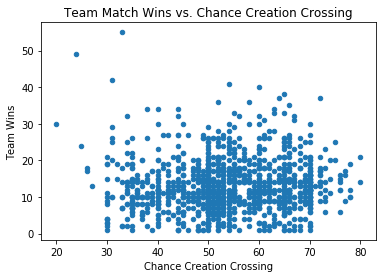

In [59]:
df_win_team.plot(x="cc_crossing", y="wins_by_attribute_period", kind="scatter");
plt.title("Team Match Wins vs. Chance Creation Crossing")
plt.xlabel("Chance Creation Crossing")
plt.ylabel("Team Wins")

There is no correlation between the number of wins and **chance creation crossing**

Text(0, 0.5, 'Team Wins')

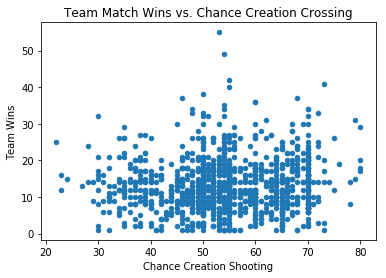

In [60]:
df_win_team.plot(x="cc_shooting", y="wins_by_attribute_period", kind="scatter");
plt.title("Team Match Wins vs. Chance Creation Crossing")
plt.xlabel("Chance Creation Shooting")
plt.ylabel("Team Wins")

There is no correlation between the number of wins and **chance creation shooting**

Text(0, 0.5, 'Team Wins')

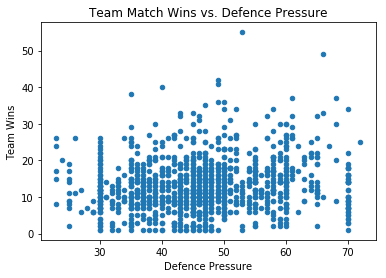

In [61]:
df_win_team.plot(x="defence_pressure", y="wins_by_attribute_period", kind="scatter");
plt.title("Team Match Wins vs. Defence Pressure")
plt.xlabel("Defence Pressure")
plt.ylabel("Team Wins")

There is no correlation between the number of wins and **defence pressure**

Text(0, 0.5, 'Team Wins')

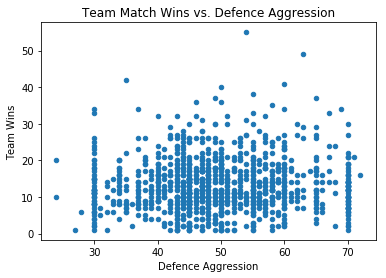

In [62]:
df_win_team.plot(x="defence_aggression", y="wins_by_attribute_period", kind="scatter");
plt.title("Team Match Wins vs. Defence Aggression")
plt.xlabel("Defence Aggression")
plt.ylabel("Team Wins")

There is no correlation between the number of wins and **defence agression**

Text(0, 0.5, 'Team Wins')

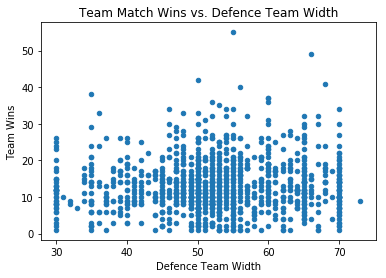

In [63]:
df_win_team.plot(x="defence_team_width", y="wins_by_attribute_period", kind="scatter");
plt.title("Team Match Wins vs. Defence Team Width")
plt.xlabel("Defence Team Width")
plt.ylabel("Team Wins")

There is no correlation between the number of wins and **defence team width**

<a id='conclusions'></a>
## Conclusions

There are no Team attributes that have an effect on the number of wins a team has.

In [54]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_Soccer_Database.ipynb'])

0